# FINAL

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [50]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange
import itertools

In [172]:
# connect to database
#dbname = 'cifar10'
#collname = 'symmetric_autoencoder'
dbname = 'deep_retina'
collname = 'vgg_models'

port = 24444

conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']

# print out saved experiments in collection coll
print(coll.distinct('exp_id'))
exp_ids = coll.distinct('exp_id')

[u'vgg16', u'vgg16_retina', u'vgg16_validation', u'retina_vgg', u'vgg16_fc6_fc7_conv5_3', u'retina_vggval_fc678', u'retina_vggval_conv5', u'retina_vggval_conv3', u'retina_vggval_conv4', u'retina_vgg_val_conv5', u'retina_vgg_val_fc']


In [173]:
exp_id = exp_ids[3]
print(exp_id)

retina_vgg


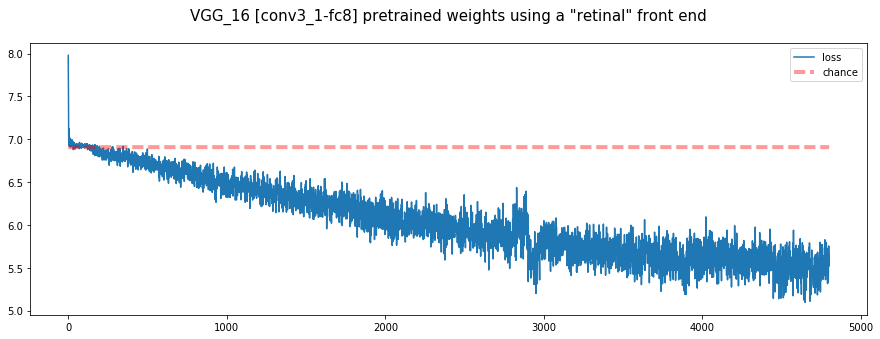

In [174]:
def get_losses(exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

plt.figure(figsize=(15,5))
loss = get_losses(exp_id)
smooth_loss = signal.convolve(loss, np.ones(1000))/1000
plt.plot(loss)
plt.plot(list(range(len(loss))), np.repeat(- np.log(.001), len(loss)), '--r', linewidth=4, alpha=.4)
plt.legend(['loss', 'chance'])
plt.title('VGG_16 [conv3_1-fc8] pretrained weights using a "retinal" front end\n', fontsize=15); 
# plt.xlabel()


In [175]:
# connect to database
#dbname = 'cifar10'
#collname = 'symmetric_autoencoder'
dbname = 'deep_retina'
collname = 'vgg_models'
exp_id = 'vgg16_retina'

port = 24444

conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']

# print out saved experiments in collection coll
print(coll.distinct('exp_id'))
exp_ids = coll.distinct('exp_id')

[u'vgg16', u'vgg16_retina', u'vgg16_validation', u'retina_vgg', u'vgg16_fc6_fc7_conv5_3', u'retina_vggval_fc678', u'retina_vggval_conv5', u'retina_vggval_conv3', u'retina_vggval_conv4', u'retina_vgg_val_conv5', u'retina_vgg_val_fc']


In [176]:
exp_id = exp_ids[3]
print(exp_id)

retina_vgg


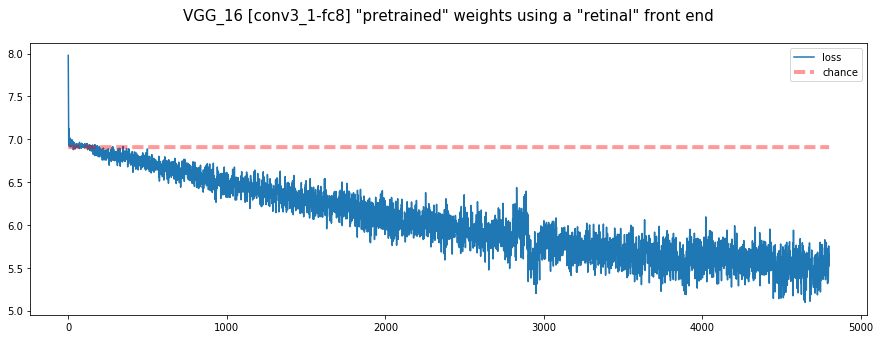

In [177]:
def get_losses(exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

plt.figure(figsize=(15,5))
loss = get_losses(exp_id)
smooth_loss = signal.convolve(loss, np.ones(1000))/1000
plt.plot(loss)
plt.plot(list(range(len(loss))), np.repeat(- np.log(.001), len(loss)), '--r', linewidth=4, alpha=.4)
plt.legend(['loss', 'chance'])
plt.title('VGG_16 [conv3_1-fc8] "pretrained" weights using a "retinal" front end\n', fontsize=15); 
# plt.xlabel()


# functions 

In [ ]:
def get_neural_validation_data(exp_id):
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])

    results = [val_steps[i] for i in range(val_steps.count())]
    for res in results:
        res['step'] = coll.find({'_id': res['validates']})[0]['step']
    #print res
    return results

In [189]:
def get_object_labels():
    """ 
    Get metadata
    """
    data_path = '/datasets/neural_data/neural_data.pkl'
    with open(data_path) as f:
        data = cPickle.load(f)
    meta = data['meta']
    labels = [np.unique(meta[meta['category'] == c]['obj']) \
                                   for c in np.unique(meta['category'])]

    labels = np.array(labels)
    labels = np.reshape(labels, (np.prod(labels.shape),))
    return labels

In [190]:
def plot_rdms(data, target_layers, labels, plot_size = [1,3]):
    """
    Displays the RDMs of all target layers.

    """
    for i, layer in enumerate(target_layers):
        rdm = data[layer]
        spearman_corrcoef = data['spearman_corrcoef_%s' % layer[4:]]
        ### YOUR CODE HERE
        plt.subplot(plot_size[0],plot_size[1] ,i+1)
        im = plt.imshow(1 - np.array(rdm), cmap='jet')
        plt.title('\n%s: spearman_corr_coeff = %g\n' %(layer, spearman_corrcoef))
        #plt.xticks(range(0,64,2), labels[0:64:2], rotation=90)
        #if i == 0 or i == 3: plt.yticks(range(1,64,2), labels[1:64:2], fontsize=8)
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=.1)
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.set_yticklabels('')
        

In [191]:
def calculate_corr(l1, l2):
    l1 = np.reshape(l1, (np.prod(l1.shape),))
    l2 = np.reshape(l2, (np.prod(l2.shape),))
    correlation = np.corrcoef(l1, l2)
    return correlation[0,1]


In [193]:
def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    
    You will need to EDIT this function.
    """
    for layer in target_layers:
        k = 'it_regression_%s' % layer[4:]
        regression_results = data[k]
        ### YOUR CODE HERE
        res = 1-regression_results['noise_corrected_multi_rsquared_loss']
        print('step', step, 'layer', layer, res)
        

In [194]:
def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    """
    res = np.zeros(len(target_layers))
    for i_layer in  range(0, len(target_layers)):
        k = 'it_regression_%s' % target_layers[i_layer][4:]
        regression_results = data[k]
        res[i_layer] = 1-regression_results['noise_corrected_multi_rsquared_loss']
        compile_regression_results['%s'%target_layers[i_layer]] = res[i_layer]
        print(target_layers[i_layer])

    plt.scatter(range(0,len(res)), res)
    plt.xlim([-.5,len(res)+.05])
    plt.xticks([-1])
    for label, x, y in zip(target_layers, range(0,len(res)), res):
        plt.annotate(label+' layer\n  (%.04f)'%res[x], xy=(x, y), xytext=(-20, -25),
            textcoords='offset points', alpha=.9, fontsize=9)
    plt.title('noise corrected multi rsquared loss for each layer\n')

## Neural analysis for conv3


In [238]:
# connect to database
#dbname = 'cifar10'
#collname = 'symmetric_autoencoder'
dbname = 'deep_retina'
collname = 'vgg_models'
exp_id = 'vgg16_retina'

port = 24444

conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']

# print out saved experiments in collection coll
print(coll.distinct('exp_id'))
exp_ids = coll.distinct('exp_id')

[u'vgg16', u'vgg16_retina', u'vgg16_validation', u'retina_vgg', u'vgg16_fc6_fc7_conv5_3', u'retina_vggval_fc678', u'retina_vggval_conv5', u'retina_vggval_conv3', u'retina_vggval_conv4', u'retina_vgg_val_conv5', u'retina_vgg_val_fc']


In [239]:
exp_id = exp_ids[-4]
print(exp_id)

retina_vggval_conv3


### Plotting the validation results
After our train_imagenet function has evaluated the Image Net validation set for the time we can have a look at the validation results of for example exp_id='experiment_1'. Again, you need to pull the validation data from the database first. The validation data consists of the top1 and top5 accuracy that you have implemented previously. 

We have provided a function that pulls the necessary data from the database. Your task is to plot the validation curve of the top1 and top5 accuracy. Label the graphs respectively and describe what you see.

In [240]:
q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
val_steps = coll.find(q_val, projection = ['validation_results'])

In [242]:
validation_data = get_neural_validation_data(exp_id)

print('data keys:')
print(validation_data[-1].keys())

data keys:
[u'exp_id', 'step', u'_id', u'validates', u'validation_results']


In [243]:
idx = 0 ### YOUR idx HERE
data = validation_data[idx]['validation_results']['valid0']
highVar_data = validation_data[0]['validation_results']['valid0']

In [244]:
target_layers = []
for key in data.keys(): 
    if 'rdm_' in key: 
        target_layers.append(key)
target_layers = target_layers[:-1]
print target_layers

[u'rdm_pool3_3', u'rdm_conv3_1', u'rdm_conv3_3', u'rdm_conv3_2']


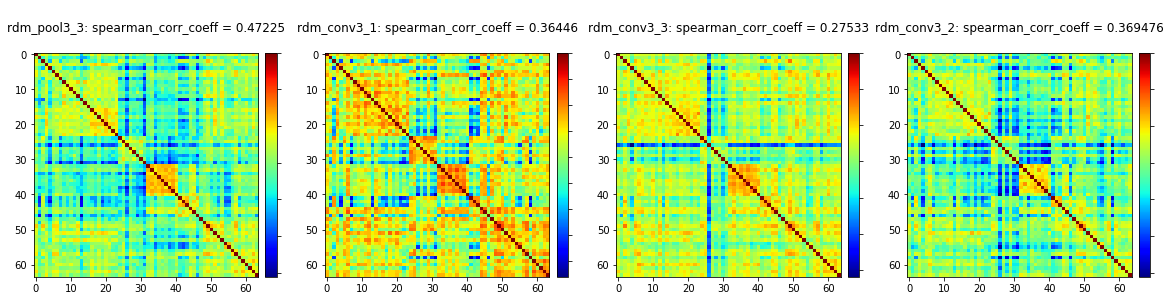

In [246]:
plt.figure(figsize=(20,13))
labels = get_object_labels()
plot_rdms(data, target_layers, labels, [1,4])

(u'Correlation between IT and rdm_conv3_3: ', 0.35224238033452576)


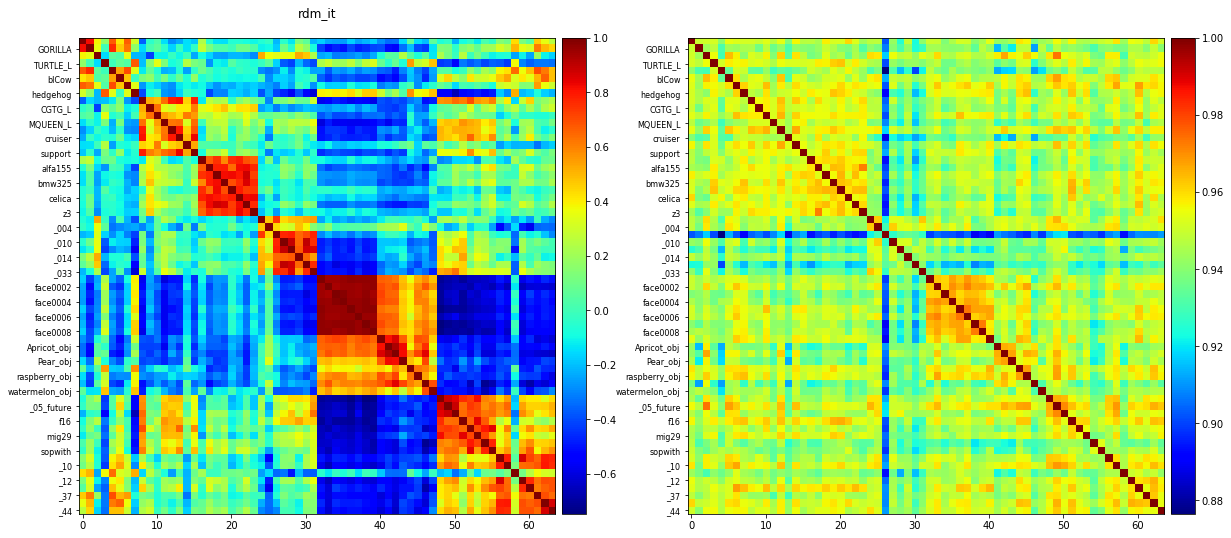

In [247]:
plt.figure(figsize=(20, 20));

labels = get_object_labels()
layer = target_layers[2]

# Plot RDM IT
plt.subplot(121)
im = plt.imshow((1-np.array(data['rdm_it'])), cmap='jet');
plt.title('rdm_it\n');
#plt.xticks(range(0,64,2), labels[0:64:2], rotation=90, fontsize=8);
plt.yticks(range(1,64,2), labels[1:64:2], fontsize=8);
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=.1)
plt.colorbar(im, cax=cax)

# Plot RDM Pool 1
plt.subplot(122);
im = plt.imshow((1-np.array(data[layer])), cmap='jet');
#plt.xticks(range(0,64,2), labels[0:64:2], rotation=90)
plt.yticks(range(1,64,2), labels[1:64:2], fontsize=8)
#plt.title(layer, '\n');
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=.1)
plt.colorbar(im, cax=cax)
### END OF YOUR CODE


correlation = calculate_corr(np.array(data['rdm_it']), np.array(data[layer]))
print('Correlation between IT and %s: '%(layer), correlation)

### Analyzing the regression results

rdm_pool3_3
rdm_conv3_1
rdm_conv3_3
rdm_conv3_2


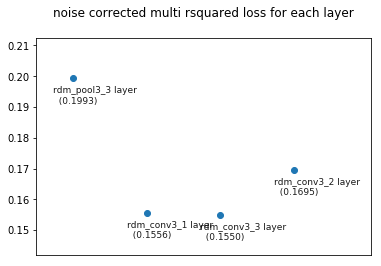

In [248]:
plot_regression_results(data, target_layers, 11000); 

In [249]:


compile_regression_results = {}



rdm_pool3_3
rdm_conv3_1
rdm_conv3_3
rdm_conv3_2


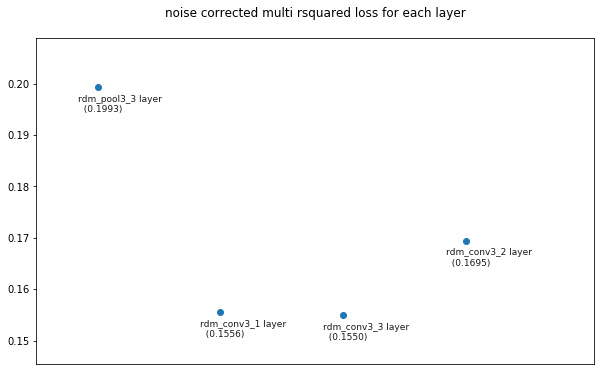

In [250]:
plt.figure(figsize=(10,6))
plot_regression_results(data, target_layers, 11000)

# results for conv4

In [260]:
# print out saved experiments in collection coll
print(coll.distinct('exp_id'))
exp_ids = coll.distinct('exp_id')

[u'vgg16', u'vgg16_retina', u'vgg16_validation', u'retina_vgg', u'vgg16_fc6_fc7_conv5_3', u'retina_vggval_fc678', u'retina_vggval_conv5', u'retina_vggval_conv3', u'retina_vggval_conv4', u'retina_vgg_val_conv5', u'retina_vgg_val_fc']


In [261]:
exp_id = exp_ids[-3]
print(exp_id)

retina_vggval_conv4


In [262]:
validation_data = get_neural_validation_data(exp_id); 
print('data keys:')
print(validation_data[-1].keys())

data keys:
[u'exp_id', 'step', u'_id', u'validates', u'validation_results']


In [263]:
idx = 0
data = validation_data[idx]['validation_results']['valid0']
highVar_data = validation_data[idx]['validation_results']['valid0']

target_layers = []
for key in data.keys(): 
    if 'rdm_' in key and not 'rdm_it' in key: 
        target_layers.append(key)
        
print target_layers

[u'rdm_pool4_3', u'rdm_conv4_2', u'rdm_conv4_3', u'rdm_conv4_1']


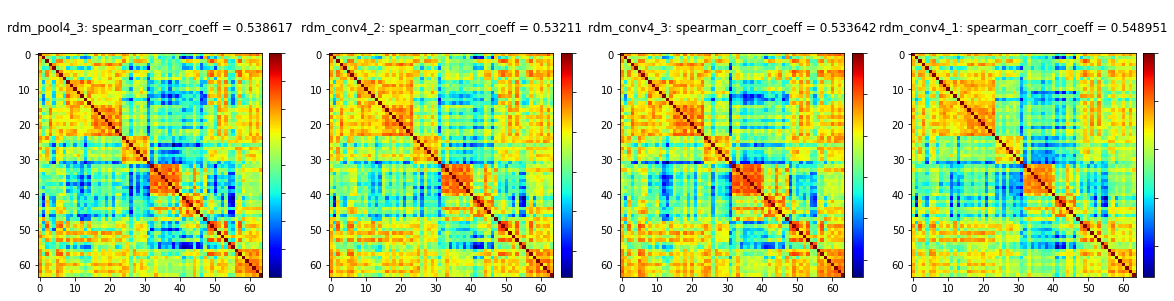

In [264]:
plt.figure(figsize=(20,13))
labels = get_object_labels()
plot_rdms(data, target_layers, labels, plot_size=[1,4])

rdm_pool4_3
rdm_conv4_2
rdm_conv4_3
rdm_conv4_1


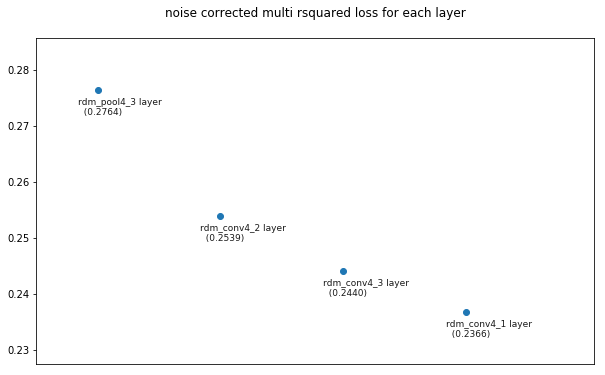

In [265]:
plt.figure(figsize=(10,6))
plot_regression_results(data, target_layers, 11000)

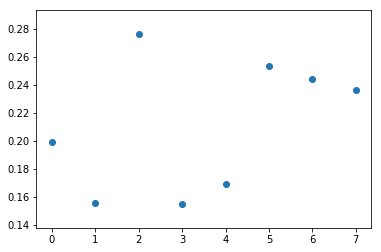

In [266]:
# def plot_regression_results(data, target_layers, step):
"""
Prints out the noise corrected multi rsquared loss for each layer.
"""
all_layers = compile_regression_results.keys()
tmp_results = np.zeros(len(compile_regression_results))
for i_layer in range(len(all_layers)):
    tmp_results[i_layer] = compile_regression_results[all_layers[i_layer]]

plt.scatter(range(len(tmp_results)), tmp_results)


# results for conv5

In [267]:
# print out saved experiments in collection coll
print(coll.distinct('exp_id'))
exp_ids = coll.distinct('exp_id')

[u'vgg16', u'vgg16_retina', u'vgg16_validation', u'retina_vgg', u'vgg16_fc6_fc7_conv5_3', u'retina_vggval_fc678', u'retina_vggval_conv5', u'retina_vggval_conv3', u'retina_vggval_conv4', u'retina_vgg_val_conv5', u'retina_vgg_val_fc']


In [268]:
exp_id = exp_ids[-2]
print(exp_id)

retina_vgg_val_conv5


In [269]:
validation_data = get_neural_validation_data(exp_id)

In [270]:
idx = 0 ### YOUR idx HERE
data = validation_data[idx]['validation_results']['valid0']
highVar_data = validation_data[idx]['validation_results']['valid0']

target_layers = []
for key in data.keys(): 
    if 'rdm_' in key and not 'rdm_it' in key: 
        target_layers.append(key)
print target_layers

[u'rdm_conv5_3', u'rdm_conv5_2', u'rdm_conv5_1']


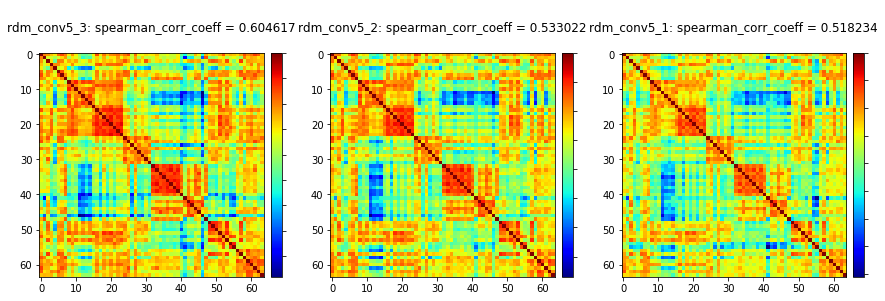

In [271]:
plt.figure(figsize=(20,13))
labels = get_object_labels()
plot_rdms(data, target_layers, labels, plot_size=[1,4])

rdm_conv5_3
rdm_conv5_2
rdm_conv5_1


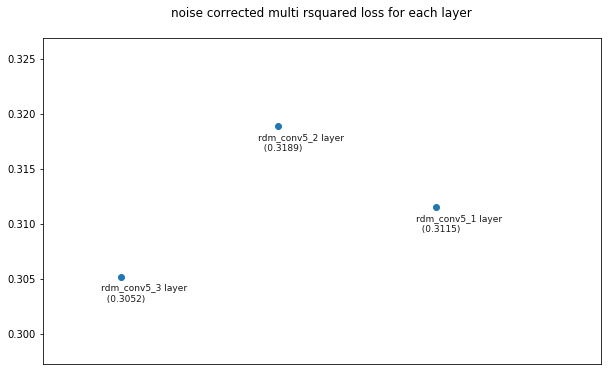

In [272]:
plt.figure(figsize=(10,6))
plot_regression_results(data, target_layers, 11000)

# results for fcs

In [273]:
exp_id = exp_ids[5]
print(exp_id)
validation_data = get_neural_validation_data(exp_id)
idx = 0 ### YOUR idx HERE
data = validation_data[idx]['validation_results']['valid0']
highVar_data = validation_data[idx]['validation_results']['valid0']

target_layers = []
for key in data.keys(): 
    if 'rdm_' in key: 
        target_layers.append(key)
target_layers = target_layers[:-1]
print target_layers

retina_vggval_fc678
[u'rdm_fc6', u'rdm_fc7', u'rdm_fc8']


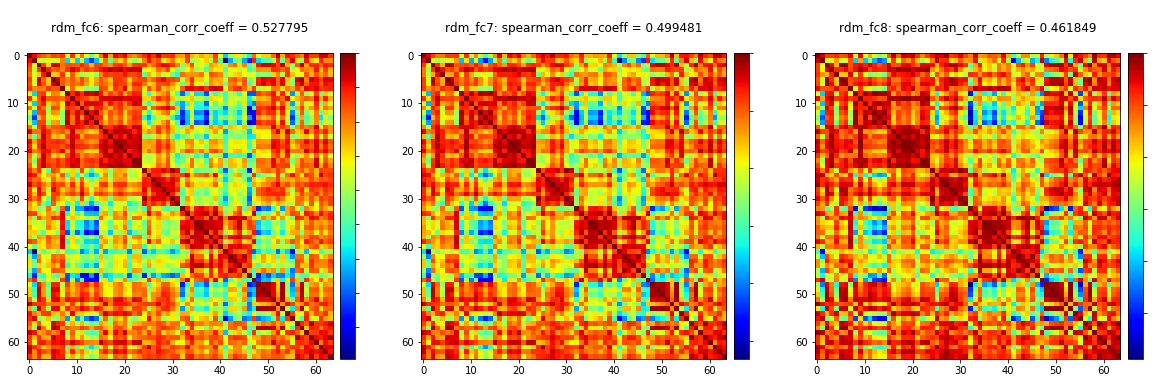

In [274]:
plt.figure(figsize=(20,13))
labels = get_object_labels()
plot_rdms(data, target_layers, labels, plot_size = [1,3])

rdm_fc6
rdm_fc7
rdm_fc8


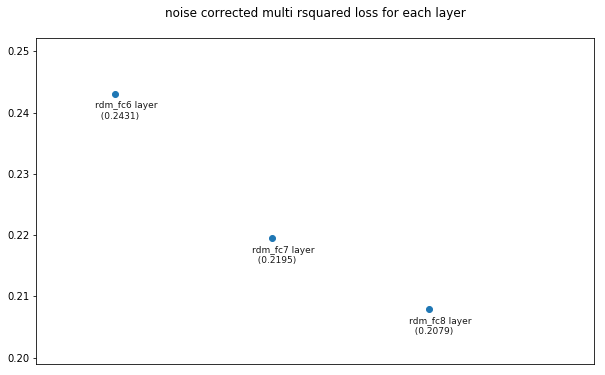

In [275]:
plt.figure(figsize=(10,6))
plot_regression_results(data, target_layers, 11000)

# all results compared to pretrained weights

In [279]:
compile_regression_results.items()

[(u'rdm_pool3_3', 0.199322651905949),
 (u'rdm_fc6', 0.24312294363751796),
 (u'rdm_fc7', 0.21953461672503183),
 (u'rdm_conv3_1', 0.15556599012560657),
 (u'rdm_pool4_3', 0.27636714856880107),
 (u'rdm_conv3_3', 0.15495638289803826),
 (u'rdm_conv3_2', 0.16948330569406544),
 (u'rdm_conv4_2', 0.25388609625247738),
 (u'rdm_conv4_3', 0.24402055376638609),
 (u'rdm_conv4_1', 0.23664629243477919),
 (u'rdm_conv5_3', 0.30522678472421672),
 (u'rdm_conv5_2', 0.31890271780688906),
 (u'rdm_conv5_1', 0.31152578500407024),
 (u'rdm_fc8', 0.20793832210280416)]

In [280]:
names = compile_regression_results.keys()
ordering = [3, 6, 5, 0, 9, 7, 8, 4,12, 11, 10, 1, 2, 13]
new_order = []
new_values = [] 
for ii in ordering: 
    new_order.append(names[ii])
    new_values.append(compile_regression_results.items()[ii][1])

In [281]:
# porting this over from instance-2

reference = {'conv5_1' : 0.36625050298004014,
             u'conv5_2': 0.38398729213059002,
             u'conv5_3': 0.37335877203271051,
             u'fc6'    : 0.45024695060320652,
             u'fc7'    : 0.37414172678281366,
             u'fc8'    : 0.33000450371964729}

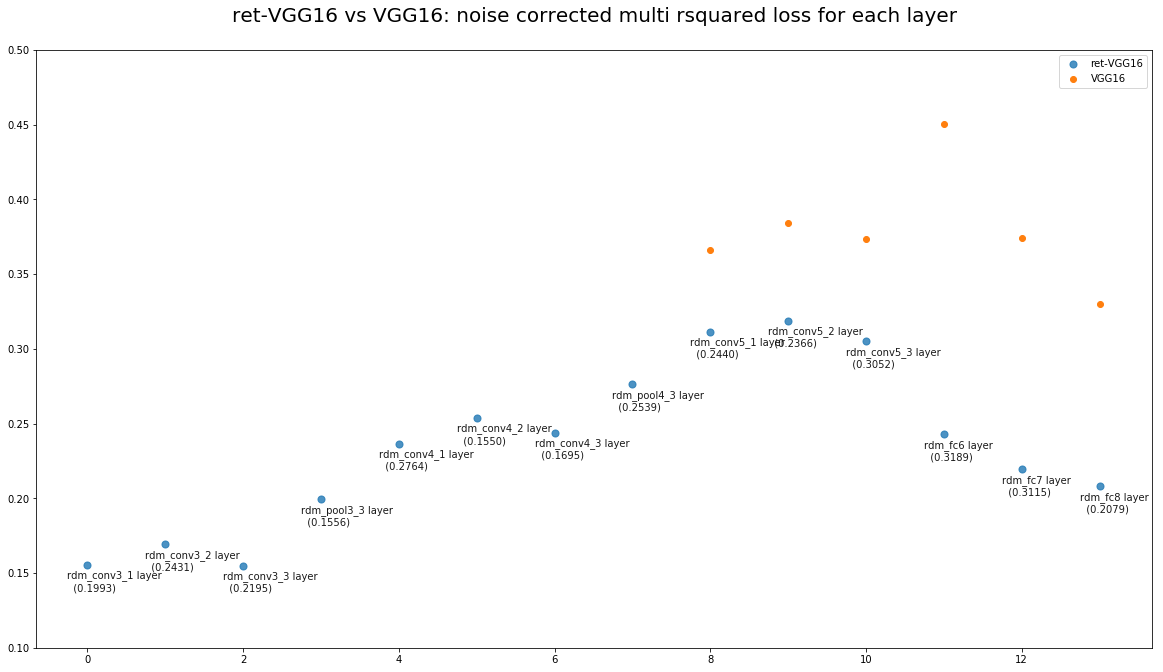

In [283]:
plt.figure(figsize=(20,11))
plt.scatter(list(range(len(new_order))), list(new_values), s=50, alpha=.8)
ref_keys = reference.keys()
plt.scatter([8, 10, 11, 12, 13, 9], list(reference.viewvalues()))
plt.ylim([.1, .5])

for label, x, y in zip(new_order, range(len(new_order)), list(new_values)):
    
    plt.annotate(label+' layer\n  (%.04f)'%list(compile_regression_results.viewvalues())[x], xy=(x, y), 
                 xytext=(-20, -25), textcoords='offset points', alpha=.9, fontsize=10)
    
    if label in ref_keys: 
        
        plt.annotate(label+' layer\n  (%.04f)'%reference[label], xy=(x, reference[label]), 
                 xytext=(-20, -25), textcoords='offset points', alpha=.9, fontsize=10)
    
plt.title('ret-VGG16 vs VGG16: noise corrected multi rsquared loss for each layer\n', fontsize=20); 
    
plt.legend(['ret-VGG16', 'VGG16']) ;      